In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, StepLR, OneCycleLR
from pathlib import Path
import matplotlib.animation as animation
from sklearn.datasets import *

from rich import print
import imageio


from utils.Models import MLP
from utils.Datasets import BBdataset
from utils.utils import *
from utils.two_dim import data_distrib

seed = 233
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 1
print(f"Using device: {device}")


experiment_name = "S2Moon_change_epsilon_norm"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

Using device: 1

In [2]:
# 生成初始和目标密度样本
def gen_data(num_samples=1000):
    source_dist = data_distrib(num_samples, 'scurve')
    target_dist = data_distrib(num_samples, 'moon')
    return source_dist, target_dist

# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = 1
    bridge = torch.zeros((ts.shape[0], num_samples, 2))
    drift = torch.zeros((ts.shape[0], num_samples, 2))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

# 主函数
def gen_2d_data(num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    source_dist, target_dist = gen_data(num_samples)
        
    # ts = torch.arange(0, T+epsilon, epsilon)

    epsilon1 = 0.001
    epsilon2 = 0.0001
    t1 = torch.arange(0, 0.91, epsilon1)
    t2 = torch.arange(0.91, T+epsilon2, epsilon2)
    # print(t1.shape, t2.shape)
    ts = torch.concatenate((t1, t2))
    
    source_dist = torch.Tensor(source_dist)
    target_dist = torch.Tensor(target_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift, source_dist, target_dist

ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=1000)

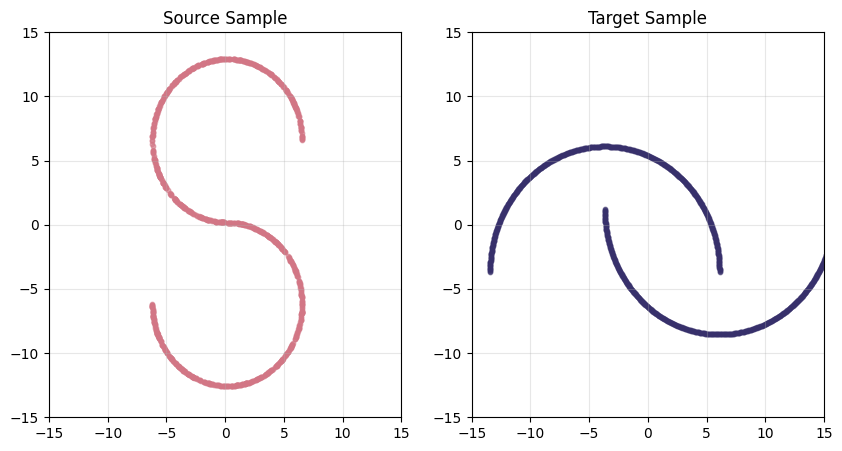

In [3]:
plot_source_and_target(source_sample, target_sample, left_title="Source Sample", right_title="Target Sample", bound=15)

In [4]:
num_samples = 12000
ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=num_samples)
# print_debug(ts, bridge, drift, source_sample, target_sample)
start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1, 1), 1, dim=1), dim=0)
times = ts[:len(ts)-1].repeat(num_samples, 1).reshape(-1, 1, 1)
positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)
# print_debug(start, times, positions, scores)
raw_data = torch.concat([start, times, positions, scores], dim=-1)
raw_data.shape

torch.Size([21720000, 1, 7])

In [5]:
# 计算均值和标准差
mean = torch.mean(raw_data, dim=0)
std = torch.std(raw_data, dim=0)

# 使用Z-Score标准化进行归一化
normalized_data = (raw_data - mean) / std

In [6]:
model = MLP(input_dim=5, output_dim=2, hidden_layers=2, hidden_dim=128).to(device)
model.mean = mean
model.std = std
loss_list = []

In [8]:
epochs = 200
batch_size = 1000000
lr = 1e-3

# 组合成data
train_ds = BBdataset(normalized_data)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=20)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dl))
# scheduler = None
loss_fn = nn.MSELoss()
# print('='*10+'model'+'='*10)
# print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
# print(model)

In [9]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data.to(device)
        # x: (batch_size, channel, length-2), y: (batch_size, channel, 2)
        x, y = training_data[:, 0, :-2], training_data[:, 0, -2:] # 不同模型要改
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

In [10]:
epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
model.to(device)
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
# torch.save(model.state_dict(), log_dir / 'model.pth')

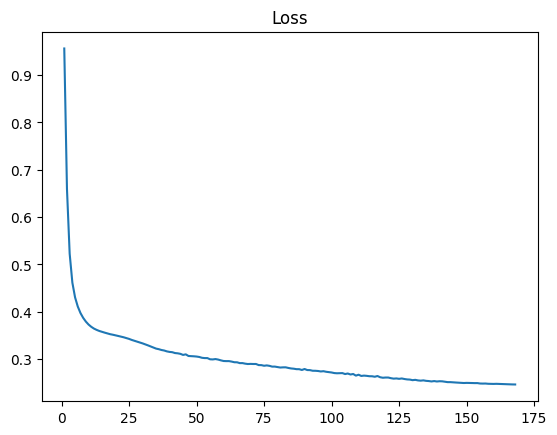

In [11]:
plt.plot(range(1, len(loss_list)+1), loss_list)
plt.title('Loss')
plt.show()

In [12]:
# model.load_state_dict(torch.load(log_dir / 'model.pth'))
test_num_samples = 4000
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_2d_data(num_samples=test_num_samples)
# print_debug(test_ts, test_bridge, test_drift, test_source_sample, test_target_sample)
pred_bridge = torch.zeros_like(test_bridge)
pred_bridge[0, :] = test_source_sample
model.eval()
sigma=1
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1, test_source_sample.shape[-1])
        test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, pred_bridge.shape[-1])
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=-1)
        x = (x - mean[:, :-2]) / std[:, :-2]
        dydt = model(x[:,0,:].to(device)).cpu()
        # dydt = dydt[:, 0, :]
        dydt = dydt * std[0,-2:] + mean[0,-2:]
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, 2)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion

        # dt = ts[i+1] - ts[i]
        # dydt = (y - bridge[i]) / (T - ts[i])
        # drift[i, :] = dydt
        # diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        # bridge[i+1] = bridge[i] + dydt * dt + diffusion

In [38]:
# draw_gaussian2d(bridge, False)

In [39]:
# draw_gaussian2d(pred_bridge, False)

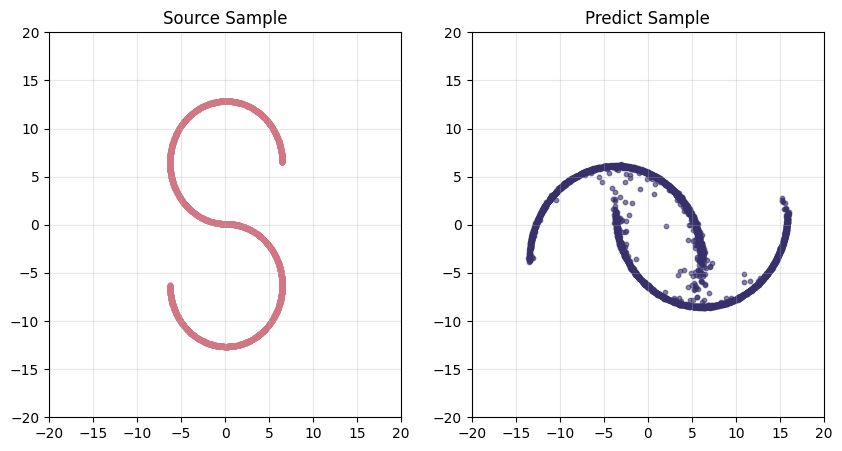

In [13]:
plot_source_and_target(pred_bridge[0, :, :], pred_bridge[-1, :, :], left_title="Source Sample", right_title="Predict Sample", save_path=log_dir / 'pred_bridge.jpg', bound=20)

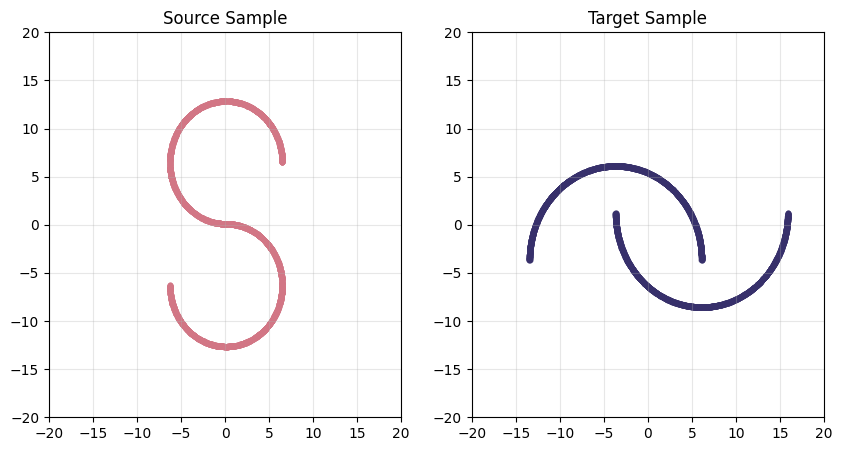

In [17]:
plot_source_and_target(test_bridge[0, :, :], test_bridge[-1, :, :], save_path=log_dir / 'gt_test_bridge.jpg', bound=20)

In [14]:
save_gif_frame(pred_bridge, log_dir, bound=20)

Output()